In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("student_data.csv")
df

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,GP,F,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,GP,F,no,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,GP,F,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,GP,F,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,GP,F,yes,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,yes,no,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9,9,9
391,MS,M,no,no,2.0,4.0,5.0,3.0,4.0,2.0,3.0,15,14,16
392,MS,M,no,no,5.0,5.0,3.0,3.0,3.0,3.0,3.0,8,10,8
393,MS,M,no,no,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11,11,12


<AxesSubplot:xlabel='grade', ylabel='count'>

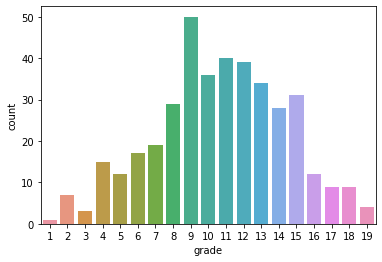

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='grade', data=df)

<AxesSubplot:>

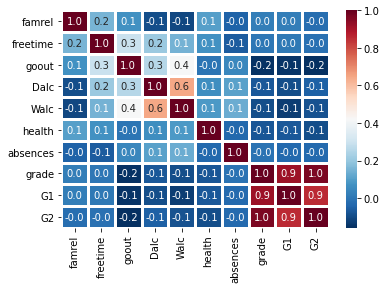

In [4]:
df_cor=df.corr(method='pearson')

sns.heatmap(df_cor, annot=True, fmt='.1f', cmap='RdBu_r', linewidth=3)

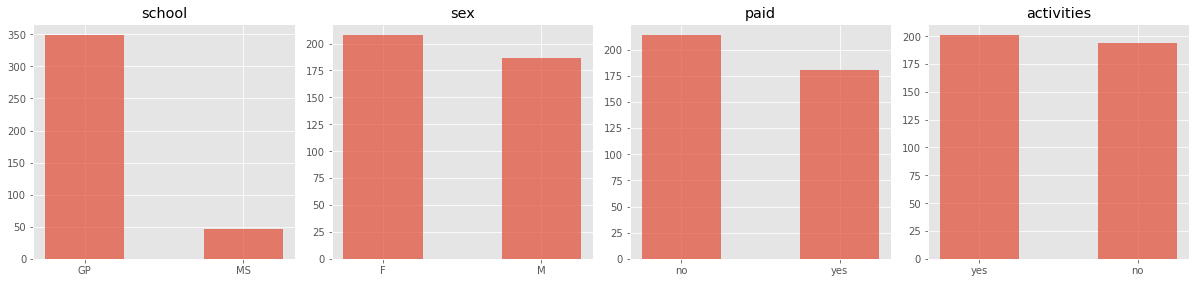

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(25,20))

cols=df.iloc[:, 0:4].columns
for i in range(len(cols)):
    plt.subplot(5,6,i+1)
    plt.title(cols[i])
    if len(df[cols[i]].unique())>10:
        plt.hist(df[cols[i]], bins=20, color='b', alpha=0.7)
        
    else:
        temp=df[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        1
freetime      2
goout         3
Dalc          4
Walc          2
health        4
absences      3
grade         0
G1            0
G2            0
dtype: int64

In [10]:
from sklearn.impute import KNNImputer

KNN_data=df.drop(columns=['school', 'sex', 'paid', 'activities'])

imputer=KNNImputer()
df_filled=imputer.fit_transform(KNN_data)
df_filled=pd.DataFrame(df_filled, columns=KNN_data.columns)
df[KNN_data.columns]=df_filled

df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
grade         0
G1            0
G2            0
dtype: int64

In [12]:
df=pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   famrel          395 non-null    float64
 1   freetime        395 non-null    float64
 2   goout           395 non-null    float64
 3   Dalc            395 non-null    float64
 4   Walc            395 non-null    float64
 5   health          395 non-null    float64
 6   absences        395 non-null    float64
 7   grade           395 non-null    float64
 8   G1              395 non-null    float64
 9   G2              395 non-null    float64
 10  school_MS       395 non-null    uint8  
 11  sex_M           395 non-null    uint8  
 12  paid_yes        395 non-null    uint8  
 13  activities_yes  395 non-null    uint8  
dtypes: float64(10), uint8(4)
memory usage: 32.5 KB


In [13]:
from sklearn.model_selection import train_test_split
X=df.drop(columns='grade')
y=df['grade']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=2022)

- 모델링

In [14]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_sc=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_sc=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

(1) SVR

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid=[{'C':[0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10]}]
grid_svm=GridSearchCV(SVR(), param_grid=param_grid, cv=5)
grid_svm.fit(X_train_sc, y_train)
print(grid_svm.best_params_)

{'C': 100, 'gamma': 0.001}


In [16]:
svr=SVR(C=100, gamma=0.001)
svr.fit(X_train_sc, y_train)
print(svr.score(X_test_sc, y_test))
print(np.sqrt(mean_squared_error(y_test, svr.predict(X_test_sc))))

0.9574163452579298
0.7753004545895938


(2) 랜덤포레스트(RandomForestRegressor)

In [20]:
rf_grid=[{'max_depth':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}]
rf=GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid=rf_grid, cv=5)
rf.fit(X_train, y_train)
print(rf.best_params_)

{'max_depth': 8, 'min_samples_split': 4}


In [21]:
rf=RandomForestRegressor(max_depth=8, min_samples_split=4, n_estimators=100)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

0.9547132187194824
0.7995291456559811


(3) XGBM(XGBRegressor)

In [22]:
xgb_grid=[{'max_depth':[2,4,6,8,10]}]
xgb=GridSearchCV(XGBRegressor(n_estimators=1000), param_grid=xgb_grid, cv=5)
xgb.fit(X_train, y_train)
xgb.best_params_

{'max_depth': 10}

In [23]:
xgb=XGBRegressor(max_depth=10, n_estimators=1000)
xgb.fit(X_train, y_train)
print(xgb.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))))

0.963211004628444
0.7206220334000073


->xgbm이 가장 성능이 좋다

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

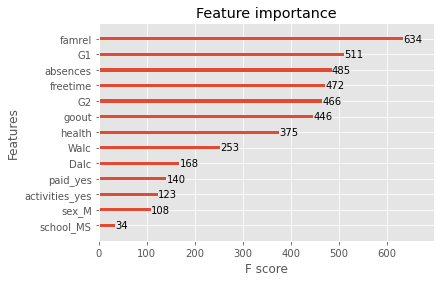

In [24]:
from xgboost import plot_importance

plot_importance(xgb)

farmrel 변수가 최종 성적에 영향을 많이 줌